In [58]:
# @Author: Gebremichael
# @File: dialogic_ADPCM.py
import wave
import numpy as np

# table of index
IndexTable = [-1, -1, -1, -1, 2, 4, 6, 8, -1, -1, -1, -1, 2, 4, 6, 8]

# table of  quantizer step size
StepSizeTable = [7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 23, 25, 28, 31, 34, 37, 41, 45, 50, 55, 60, 66, 73, 80, 88, 97, 107, 118, 130, 143, 157, 173, 190, 209, 230, 253, 279, 307, 337, 371, 408, 449, 494, 544, 598, 658, 724, 796, 876, 963, 1060, 1166, 1282, 1411, 1552, 1707, 1878, 2066, 2272, 2499, 2749, 3024, 3327, 3660, 4026, 4428, 4871, 5358, 5894, 6484, 7132, 7845, 8630, 9493, 10442, 11487, 12635, 13899, 15289, 16818, 18500, 20350, 22385, 24623, 27086, 29794, 32767]

# ADPCM_Encode.
# sample: a 16-bit PCM sample
# retval : a 4-bit ADPCM sample
predsample = 0
index = 0

# This method .......
def ADPCM_Encode(sample):
    global index
    global predsample
    global diffq
    global ore_diff
    global error_signal
    
    code = 0
    
    step_size = StepSizeTable[index]

    # compute diff and record sign and absolut value
          
    diff = sample - predsample
    ore_diff=diff
    #print('diff sample:' ,ore_diff)
    if diff < 0:
        code = 8
        diff = -diff

    # quantize the diff into ADPCM code
    # inverse quantize the code into a predicted diff
    tmpstep = step_size
    diffq = step_size >> 3
    if diff >= tmpstep:
        code = code | 0x04
        diff -= tmpstep
        diffq = diffq + step_size

    tmpstep = tmpstep >> 1
    if diff >= tmpstep:
        code = code | 0x02
        diff = diff - tmpstep
        diffq = diffq + (step_size >> 1)

    tmpstep = tmpstep >> 1
    if diff >= tmpstep:
        code = code | 0x01
        diffq = diffq + (step_size >> 2)
    
    # fixed predictor to get new predicted sample
    predsample=predictor(code,predsample,diffq)

    # find new stepsize index
    index += IndexTable[code]

    # check for overflow
    if index < 0:
        index = 0

    if index > 88:
        index = 88
    error_signal = sample - predsample
    
    # return new ADPCM code code & 0x0f == code
    return code & 0x0f



def predictor(code,predsample,diffq):
    if code & 8:
        predsample = predsample - diffq
    else:
        predsample = predsample + diffq
         
    # check for overflow
    if predsample > 32767:
        predsample = 32767
    elif predsample < -32768:
        predsample = -32768
        
    return predsample

In [59]:
# ADPCM_Decode.
# code: a byte containing a 4-bit ADPCM sample.
# retval: 16-bit ADPCM sample

de_index = 0
de_predsample = 0

# Work well
def ADPCM_Decode(code):
    global de_index
    global de_predsample

    step_size = StepSizeTable[de_index]

    # inverse code into diff    
    diffq = step_size >> 3  # == step/8
    if code & 4:
        diffq += step_size

    if code & 2:
        diffq += step_size >> 1

    if code & 1:
        diffq += step_size >> 2

    #print('diffq:' ,diffq)
    
    # add diff to predicted sample
    if code & 8:
        diffq = -diffq

    de_predsample += diffq

    # check for overflow  clip the values to +/- 2^11 (supposed to be 16 bits)
    if de_predsample > 32767:
        de_predsample = 32767
    elif de_predsample < -32768:
        de_predsample = -32768

    # find new quantizer step size
    de_index += IndexTable[code]

    # check for overflow
    if de_index < 0:
        de_index = 0

    if de_index > 88:
        de_index = 88

    # save predict sample and de_index for next iteration
    # return new decoded sample
    # The original algorithm turned out to be 12bit, need to convert to 16bit
    return de_predsample

In [60]:

import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np

import wave
from scipy.io import wavfile

np.set_printoptions(threshold=np.inf)
audio_file = 'C:/Users/GM/Desktop/audio_data/myspeech.wav'
fs, wavdata = wavfile.read(audio_file)
wavdata=wavdata[::1]
#print(fs)
#print(wavdata[:10])

wavdata, fs = librosa.load(audio_file, sr = 44100)
wavdata=wavdata[:]
#gm=audio[:10]
#print(fs)
#print(audio[:10])

org_samp=[]
pre_samp=[]
oreginal_diff=[]
adpcm_code = []
q_diff=[]
err_signal=[]
for i in range(len(wavdata)):
    sample = ADPCM_Encode(wavdata[i])   
    pred_sample = ADPCM_Decode(sample)
    #print("Sample:", wavdata[i])
    #print("ADPCM code:", sample)
    #print('Estmated PCM:', predsample)
    #print('................................')
    
    org_samp.append(wavdata[i])
    pre_samp.append(pred_sample)
    oreginal_diff.append(ore_diff)
    adpcm_code.append(sample)
    q_diff.append(diffq)
    err_signal.append(error_signal)

    
org_samp=np.array(org_samp)           #oreginal signal samples
pre_samp=np.array(pre_samp)           #predicted sample 
oreginal_diff=np.array(oreginal_diff) #the oreginal and predicted sample difference
adpcm_code = np.array(adpcm_code)     #the ADPCM code the is transmited to decoder 
q_diff = np.array(q_diff)             #the quantized difference/inverse of quantization difference
e_signal=np.array(err_signal)         #the error of the prediction (residual signal)

In [61]:
#org_samp[7000:7100]

In [62]:
#pre_samp[6999:7099]

In [63]:
#oreginal_diff[7000:7100]

In [64]:
#adpcm_code[7000:7100]

In [65]:
#q_diff[7000:7100] 

In [66]:
#e_signal[7000:7100]

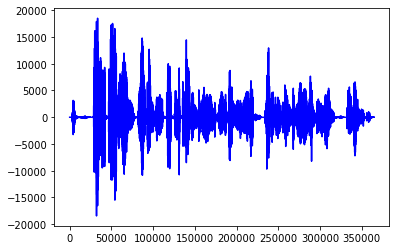

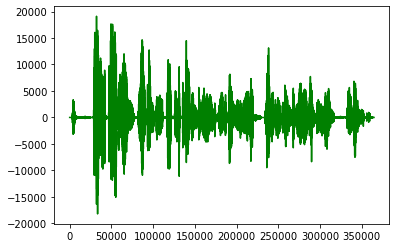

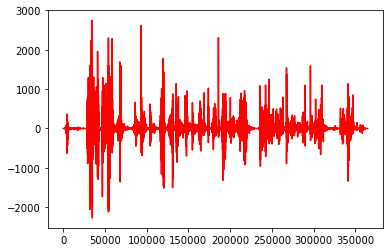

In [70]:
# Oreginal speech signal data
plt.plot(org_samp[:], 'b')
plt.show()

# Predicted speech signal data
plt.plot(pre_samp[:], 'g')
plt.show()

# Error speech signal data
plt.plot(e_signal[:], 'r')
plt.show()

In [68]:
ipd.display(ipd.Audio(data=org_samp[:], rate=44100))

In [69]:
ipd.display(ipd.Audio(data=pre_samp[:], rate=44100))